In [1]:
!mdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: line 1: mdir: command not found
cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download abdulvahap/music-instrunment-sounds-for-classification

Dataset URL: https://www.kaggle.com/datasets/abdulvahap/music-instrunment-sounds-for-classification
License(s): apache-2.0
100% 4.59G/4.59G [01:03<00:00, 99.4MB/s]
100% 4.59G/4.59G [01:04<00:00, 77.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('music-instrunment-sounds-for-classification.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import glob
import random
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [5]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPool2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [7]:
from IPython.display import Audio

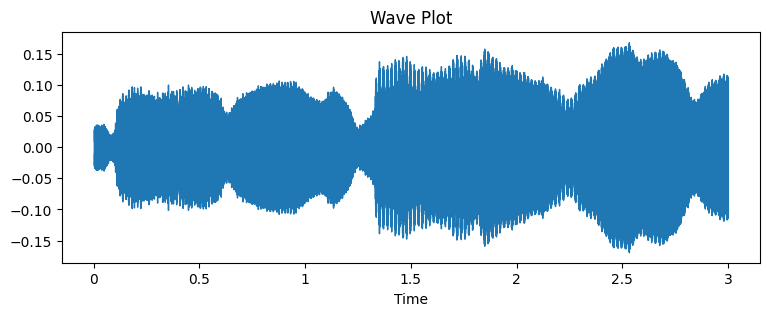

[ 0.00973511  0.01531982  0.01846313 ... -0.02261353 -0.00457764
  0.0145874 ]
22050


In [8]:
# Flute Sample for how we check wave of sound
filename = '/content/music_dataset/flute/10.wav'
plt.figure(figsize=(9,3))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
plt.title('Wave Plot')
plt.show()
print(data)
print(sample_rate)

In [ ]:
Audio(data=data, rate=sample_rate)

Melspectrogram Visualization

In [9]:
def plot_melspectrogram(y, sr):
  spectogram = librosa.feature.melspectrogram(y=data, sr=sample_rate)
  spectogram_db = librosa.power_to_db(spectogram, ref=np.max)
  plt.figure(figsize=(9,3))
  librosa.display.specshow(spectogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.tight_layout()
  plt.show()

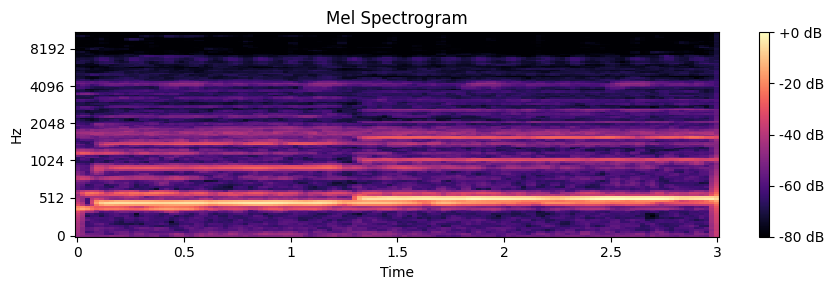

In [10]:
plot_melspectrogram(data, sample_rate)

In [11]:
print(sorted(os.listdir('/content/music_dataset')))

['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']


# Data Preprocessing

In [12]:
main_path = '/content/music_dataset'
label = ['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']

In [13]:
from tensorflow.image import resize

**write a function to extract feature from detaset use librosa and mfccs (Mel Frequency Cepstral Coefficients) we use this function to preprocess our audio file and find a frequency with respect to time of our audio this process give a accurate result than SciPy. we know the audio form a wave with certain frequency on the basis of frequency wave we know how the sound form.**

In [14]:
def extract_features(main_path, label):
  data = []
  labels = []
  for i_class, class_name in enumerate(label):
    path = os.path.join(main_path, class_name)
    print('preprocessing -- ',class_name)
    for file_name in os.listdir(path):
      if file_name.endswith('.wav'):
        file_path = os.path.join(path, file_name)
        audio_data, sample_rate = librosa.load(file_path, sr=None)

        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=80)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        # Reshape for model input
        mfccs_scaled = mfccs_scaled.reshape(80, 1, 1)

        data.append(mfccs_scaled)
        labels.append(i_class)
  return np.array(data), np.array(labels)

In [15]:
data, labels = extract_features(main_path, label)

preprocessing --  Accordion
preprocessing --  Acoustic_Guitar
preprocessing --  Banjo
preprocessing --  Bass_Guitar
preprocessing --  Clarinet
preprocessing --  Cymbals
preprocessing --  Dobro
preprocessing --  Drum_set
preprocessing --  Electro_Guitar
preprocessing --  Floor_Tom
preprocessing --  Harmonica
preprocessing --  Harmonium
preprocessing --  Hi_Hats
preprocessing --  Horn
preprocessing --  Keyboard
preprocessing --  Mandolin
preprocessing --  Organ
preprocessing --  Piano
preprocessing --  Saxophone
preprocessing --  Shakers
preprocessing --  Tambourine
preprocessing --  Trombone
preprocessing --  Trumpet
preprocessing --  Ukulele
preprocessing --  Violin
preprocessing --  cowbell
preprocessing --  flute
preprocessing --  vibraphone


In [16]:
data.shape

(42311, 80, 1, 1)

In [17]:
labels.shape

(42311,)

In [18]:
# convert label into one-hot-encoding
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, num_classes=len(label))
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [19]:
labels.shape

(42311, 28)

In [20]:
X,y = data, labels

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [22]:
X_train.shape

(33848, 80, 1, 1)

In [29]:
from tensorflow.keras.layers import LSTM, Dropout, SimpleRNN

In [24]:
# RNN model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=len(label), activation='softmax'))

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 80, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 80, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 80, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 80, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 28)                  │             924 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,308 (505.11 KB)

 Trainable params: 129,308 (505.11 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.4390 - loss: 2.0759 - val_accuracy: 0.7104 - val_loss: 1.0050
Epoch 2/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7217 - loss: 0.9767 - val_accuracy: 0.7712 - val_loss: 0.7577
Epoch 3/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7748 - loss: 0.7714 - val_accuracy: 0.8258 - val_loss: 0.5810
Epoch 4/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8158 - loss: 0.6290 - val_accuracy: 0.8457 - val_loss: 0.5111
Epoch 5/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.8520 - loss: 0.5206 - val_accuracy: 0.8749 - val_loss: 0.4264
Epoch 6/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.8726 - loss: 0.4493 - val_accuracy: 0.8957 - val_loss: 0.3582
Epoch 7/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8923 - loss: 0.3761 - val_accuracy: 0.9043 - val_loss: 0.3269
Epoch 8/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9108 -

In [27]:
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9276 - loss: 0.2657
Validation Loss: 0.2675100564956665, Validation Accuracy: 0.9280397295951843


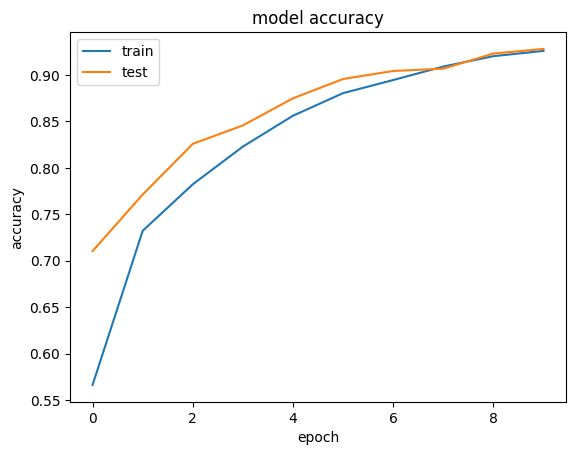

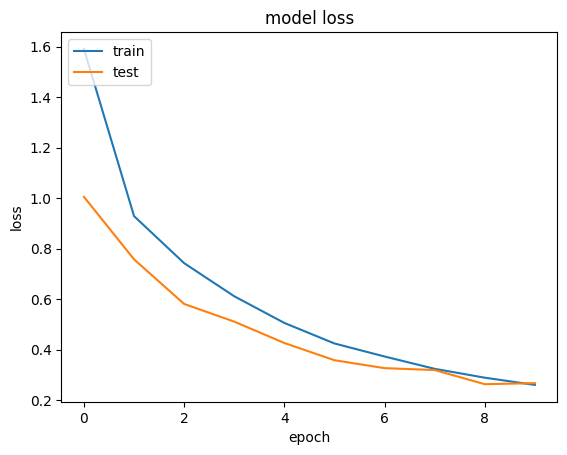

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN MODEL

In [36]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(80, 1, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64, kernel_size=(3, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, kernel_size=(3, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=256, kernel_size=(3, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=512, kernel_size=(3, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(label), activation='softmax'))



In [37]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 80, 1, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 80, 1, 32)           │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 40, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 40, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 40, 1, 64)           │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 20, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 20, 1, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 10, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 1, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 5, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 5, 1, 512)           │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 2, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 667,900 (2.55 MB)

 Trainable params: 667,900 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.3804 - loss: 2.2093 - val_accuracy: 0.7950 - val_loss: 0.6815
Epoch 2/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.7516 - loss: 0.8485 - val_accuracy: 0.8670 - val_loss: 0.4444
Epoch 3/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8111 - loss: 0.6477 - val_accuracy: 0.8830 - val_loss: 0.3815
Epoch 4/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8397 - loss: 0.5589 - val_accuracy: 0.8992 - val_loss: 0.3361
Epoch 5/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8560 - loss: 0.5118 - val_accuracy: 0.9174 - val_loss: 0.2703
Epoch 6/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8720 - loss: 0.4399 - val_accuracy: 0.9218 - val_loss: 0.2719
Epoch 7/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8822 - loss: 0.4102 - val_accuracy: 0.9316 - val_loss: 0.2257
Epoch 8/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8858 - loss: 0.4013

In [41]:
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9545 - loss: 0.1604
Validation Loss: 0.16724015772342682, Validation Accuracy: 0.9502540230751038


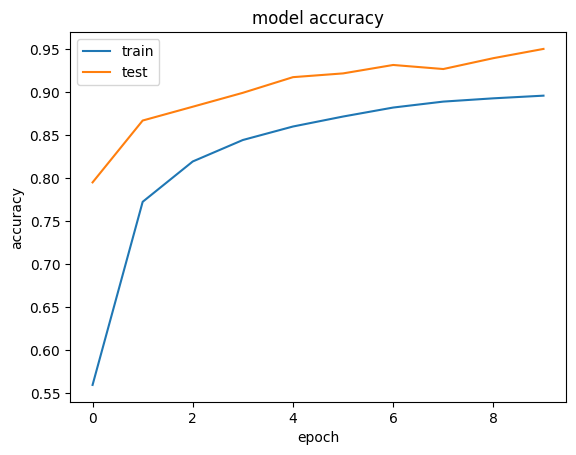

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

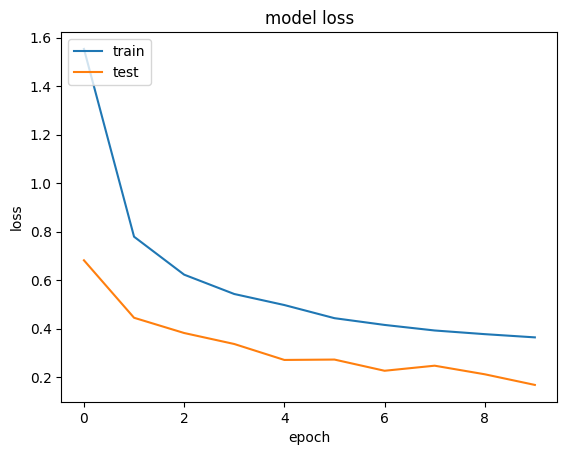

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print('Final training accuracy: ', history.history['accuracy'][-1])
print('Final validation accuracy: ', history.history['val_accuracy'][-1])

Final training accuracy:  0.849001407623291
Final validation accuracy:  0.8857378959655762


In [ ]:

def predict_audio(file_path, model, label):
  audio_data, sample_rate = librosa.load(file_path, sr=None)
  mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=80)
  mfccs_scaled = np.mean(mfccs.T, axis=0)
  mfccs_scaled = mfccs_scaled.reshape(1, 80, 1, 1) # Reshape for model input (add batch dimension)
  prediction = model.predict(mfccs_scaled)
  predicted_class_index = np.argmax(prediction)
  predicted_label = label[predicted_class_index]
  return predicted_label, prediction




In [ ]:
# Example usage (assuming 'model' and 'label' are defined from previous code):
file_path = '/content/music_dataset/Organ/1003.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Predicted Label: Organ
Probabilities: [[2.06253503e-08 2.33462671e-09 9.69524415e-14 2.92439056e-18
  1.03394564e-08 7.55771112e-10 1.09090556e-10 3.08077487e-15
  4.07595380e-09 1.26814679e-11 2.05973173e-12 3.72004350e-20
  2.38983330e-11 4.28468928e-18 2.14189817e-18 5.08295229e-12
  9.99963760e-01 1.45573500e-08 1.49883714e-08 6.34517873e-17
  1.46613514e-18 6.24244649e-06 2.81416451e-05 1.71280510e-06
  1.56603779e-16 6.83023388e-21 8.00080556e-15 1.36113428e-07]]


In [ ]:
file_path = '/content/ROOM_room6_MUS_pachelbel_DEV_amazon.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Label: Piano


In [ ]:
file_path = '/content/guitar-solo-74247.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: Hi_Hats


In [ ]:
file_path = '/content/Va-ord-F4-ff-2c.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Label: Clarinet


In [ ]:
file_path = '/content/rock-drum-loop-85371.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Label: Floor_Tom


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/Test_submission.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:

def predict_audio_folder(folder_path, model, label):
  for filename in os.listdir(folder_path):
    if filename.endswith(('.wav', '.mp3')): # Adjust extensions if needed
      file_path = os.path.join(folder_path, filename)
      try:
        predicted_label, probabilities = predict_audio(file_path, model, label)
        print(f"File: {filename}, Predicted Label: {predicted_label}")
      except Exception as e:
        print(f"Error processing {filename}: {e}")




In [ ]:
# Example usage:
test_folder = '/content/Test_submission' # Replace with the actual path to your test folder
predict_audio_folder(test_folder, model, label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
File: Va-ord-F4-mf-3c.wav, Predicted Label: Ukulele
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
File: Sad-Violin-Fast-E-www.fesliyanstudios.com.wav, Predicted Label: Ukulele
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
File: guitar-song-57789.wav, Predicted Label: Acoustic_Guitar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
File: darbuka-drum-percussion-64018.wav, Predicted Label: Floor_Tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
File: guitar-solo-5999.wav, Predicted Label: Mandolin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
File: pulsing-rhythm-31775.wav, Predicted Label: Hi_Hats
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
File: Va-ord-E4-mf-3c.wav, Predicted Label: Accordion
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
File: Va-ord-F5-mf-3c.wav, Predicted Label: Banjo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
File: whatever-you-say-piano-27291.wav, Predicted Label: Piano
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
File: ROOM_room7_MUS_beethoven1_DEV_amazon.wav, Predicted Label: Piano
1/1 ━━━━━━━